# Financiera Compartamos
-----------------------------------------

In [1]:
# warnings
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("./lib/")
# for graphics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lib.FuncionesGenerales import Builder

# import data
diccionario = {
    'codigoCredito': str,
    'codigoCliente': str,
    'codigoOficina': str
}

dfCompleto = pd.read_excel('data/dataFinal.xlsx', dtype=diccionario)
dfSegmentacion = pd.read_csv('data/Segmentacion.csv')
ibuilder = Builder(dfCompleto)
respaldo = dfCompleto.copy()

## Exploración de Datos

In [2]:
dfCompleto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29731 entries, 0 to 29730
Data columns (total 15 columns):
codigoCredito       29731 non-null object
codigoCliente       29731 non-null object
codigoOficina       29731 non-null object
tipoCredito         29731 non-null object
moneda              29731 non-null object
sector              29731 non-null object
destinoCredito      29731 non-null object
fechaAperturaMin    29731 non-null datetime64[ns]
fechaAperturaMax    29731 non-null datetime64[ns]
montoApertura       29731 non-null float64
numeroCuotas        29731 non-null int64
montoCancelado      29731 non-null float64
interes             29731 non-null float64
condicionCredito    29731 non-null object
esDeudor            29731 non-null int64
dtypes: datetime64[ns](2), float64(3), int64(2), object(8)
memory usage: 3.4+ MB


In [3]:
dfCompleto.head(3)

,codigoCredito,codigoCliente,codigoOficina,tipoCredito,moneda,sector,destinoCredito,fechaAperturaMin,fechaAperturaMax,montoApertura,numeroCuotas,montoCancelado,interes,condicionCredito,esDeudor
0,001710000017,0140149899,001,RECUPERADO ...,SOLES ...,PEQUEÑAS EMPRESAS ...,CAPITAL DE TRABAJO INFORMAL ...,2017-08-07,2017-08-07,2500.0,12,2151.83,674.10,CASTIGADO (V) ...,1
1,001710000066,0140188681,001,RECURRENTE ...,SOLES ...,PEQUEÑAS EMPRESAS ...,ACTIVO FIJO INFORMAL ...,2017-04-03,2017-08-07,10000.0,24,9376.37,2286.73,CASTIGADO (V) ...,1
2,001710000090,0260173521,001,RECURRENTE ...,SOLES ...,MICROEMPRESA ...,ACTIVO FIJO INFORMAL ...,2017-08-07,2017-08-07,1058.5,12,748.80,284.31,CASTIGADO (V) ...,1


### Trabajando con los datos cualitativos

In [4]:
dfCompleto.describe(include=['object'])

,codigoCredito,codigoCliente,codigoOficina,tipoCredito,moneda,sector,destinoCredito,condicionCredito
count,29731,29731,29731,29731,29731,29731,29731,29731
unique,29731,27506,9,6,1,4,7,5
top,035710151560,0014201115,005,RECURRENTE,SOLES ...,MICROEMPRESA ...,ACTIVO FIJO INFORMAL ...,NORMAL ...
freq,1,3,4949,13648,29731,18148,15423,26494


_Establecer como index a codigoCredito y cambiar codigoCliente a flag cuenta única_

In [5]:
dftest = dfCompleto['codigoCredito'].groupby([dfCompleto['codigoCliente']]).count()
md1c = dftest.index[dftest==1]
dfCompleto['cuentaUnica']=dfCompleto.codigoCliente.isin(md1c) #1 si es unica, 0 si tiene mas de una cuenta
dfCompleto.cuentaUnica=dfCompleto.cuentaUnica.apply(int)
dfCompleto.drop(['codigoCliente'], axis=1, inplace=True)
dfCompleto = dfCompleto.set_index('codigoCredito')

_Analizamos la distribución de los datos cualitativos_

In [6]:
display(pd.value_counts(dfCompleto.codigoOficina))
display(pd.value_counts(dfCompleto.tipoCredito))
display(pd.value_counts(dfCompleto.moneda))
display(pd.value_counts(dfCompleto.sector))
display(pd.value_counts(dfCompleto.destinoCredito))
display(pd.value_counts(dfCompleto.condicionCredito))

005    4949
036    4585
012    4011
007    3969
001    2771
008    2743
038    2557
035    2470
018    1676
Name: codigoOficina, dtype: int64

RECURRENTE                                                                13648
RECUPERADO                                                                 5684
NUEVO                                                                      4020
RECURRENTE                                                                 3560
NUEVO                                                                      1462
RECUPERADO                                                                 1357
Name: tipoCredito, dtype: int64

SOLES                                                                     29731
Name: moneda, dtype: int64

MICROEMPRESA                                                              18148
PEQUEÑAS EMPRESAS                                                          7643
CONSUMO NO REVOLVENTE                                                      3932
MEDIANAS EMPRESAS                                                             8
Name: sector, dtype: int64

ACTIVO FIJO INFORMAL                                                      15423
CAPITAL DE TRABAJO INFORMAL                                                8782
CONSUMO                                                                    3932
CAPITAL DE TRABAJO FORMAL                                                   849
ACTIVO FIJO FORMAL                                                          742
MIXTO INFORMAL                                                                2
VIVIENDA                                                                      1
Name: destinoCredito, dtype: int64

NORMAL                                                                    26494
CASTIGADO (V)                                                              1524
VENCIDO                                                                    1037
VENCIDO +120 DIAS                                                           614
JUDICIAL                                                                     62
Name: condicionCredito, dtype: int64

#### Se realizarán los siguientes cambios:
- __codigoOficina:__ Se podría agrupar por distritos, ciudades pero no se tiene información, no se modificará.
- __tipoCredito:__ Se repiten los campos que son lo mismo, se limpiará los espacios.
- __moneda:__ Se retira este campo por no ser de influencia
- __sector:__ Se juntará MEDIANAS EMPRESAS y PEQUEÑAS EMPRESAS como PYMES debido a su distribución
- __destinoCredito:__ Se retira vivienda, por no ser afín de las categorías y se retiran mixto informal pues hay trabajo y activo se mantendrán separados.
- __condicionCredito:__ La condicion es posterior al prestamo, se evaluará

In [7]:
dfCompleto['tipoCredito'] = dfCompleto.tipoCredito.apply(lambda x: x.replace(" ",""))
dfCompleto.drop(['moneda'], axis=1, inplace=True)
dfCompleto['sector'] = dfCompleto.sector.apply(lambda x: x.replace(" ",""))
dfCompleto.sector.replace(to_replace=dict(MEDIANASEMPRESAS='PYMES', PEQUEÑASEMPRESAS='PYMES', CONSUMONOREVOLVENTE='CONSUMO'), inplace=True)
dfCompleto['destinoCredito'] = dfCompleto.destinoCredito.apply(lambda x: x.replace(" ",""))
dfCompleto = dfCompleto[dfCompleto.destinoCredito != 'MIXTOINFORMAL']
dfCompleto = dfCompleto[dfCompleto.destinoCredito != 'VIVIENDA']
dfCompleto.destinoCredito.replace(to_replace=dict(ACTIVOFIJOINFORMAL='AFINFORMAL',
                          CAPITALDETRABAJOINFORMAL='CTINFORMAL', CAPITALDETRABAJOFORMAL='CTFORMAL', ACTIVOFIJOFORMAL='AFFORMAL'), inplace=True)
dfCompleto['condicionCredito'] = dfCompleto.condicionCredito.apply(lambda x: x.replace(" ",""))
dfCompleto.describe(include=['object'])

,codigoOficina,tipoCredito,sector,destinoCredito,condicionCredito
count,29728,29728,29728,29728,29728
unique,9,3,3,5,5
top,005,RECURRENTE,MICROEMPRESA,AFINFORMAL,NORMAL
freq,4948,17205,18147,15423,26492


### Datos Cuantitativos

In [8]:
dfCompleto.describe(include=['int64', 'float'])

,montoApertura,numeroCuotas,montoCancelado,interes,esDeudor,cuentaUnica
count,29728.000000,29728.000000,29728.000000,29728.000000,29728.000000,29728.000000
mean,12263.696145,16.458759,7898.627448,3212.341154,0.214545,0.853034
std,15977.355891,7.940662,12057.044968,4337.829264,0.410513,0.354078
min,500.000000,1.000000,0.050000,56.120000,0.000000,0.000000
25%,2078.000000,12.000000,1031.370000,583.237500,0.000000,1.000000
50%,5058.500000,12.000000,2823.400000,1327.195000,0.000000,1.000000
75%,15000.000000,18.000000,8967.087500,3879.530000,0.000000,1.000000
max,150000.000000,72.000000,121922.710000,62201.960000,1.000000,1.000000


__Datos binarios__

In [9]:
display(pd.value_counts(dfCompleto.esDeudor))
display(pd.value_counts(dfCompleto.cuentaUnica))

0    23350
1     6378
Name: esDeudor, dtype: int64

1    25359
0     4369
Name: cuentaUnica, dtype: int64

_montoCancelado se retirará debiado a que no es un dato que se considere al generar un crédito, evaluaremos las distribuciones de los demás campos respecto a si es deudor o no_

<IPython.core.display.Javascript object>


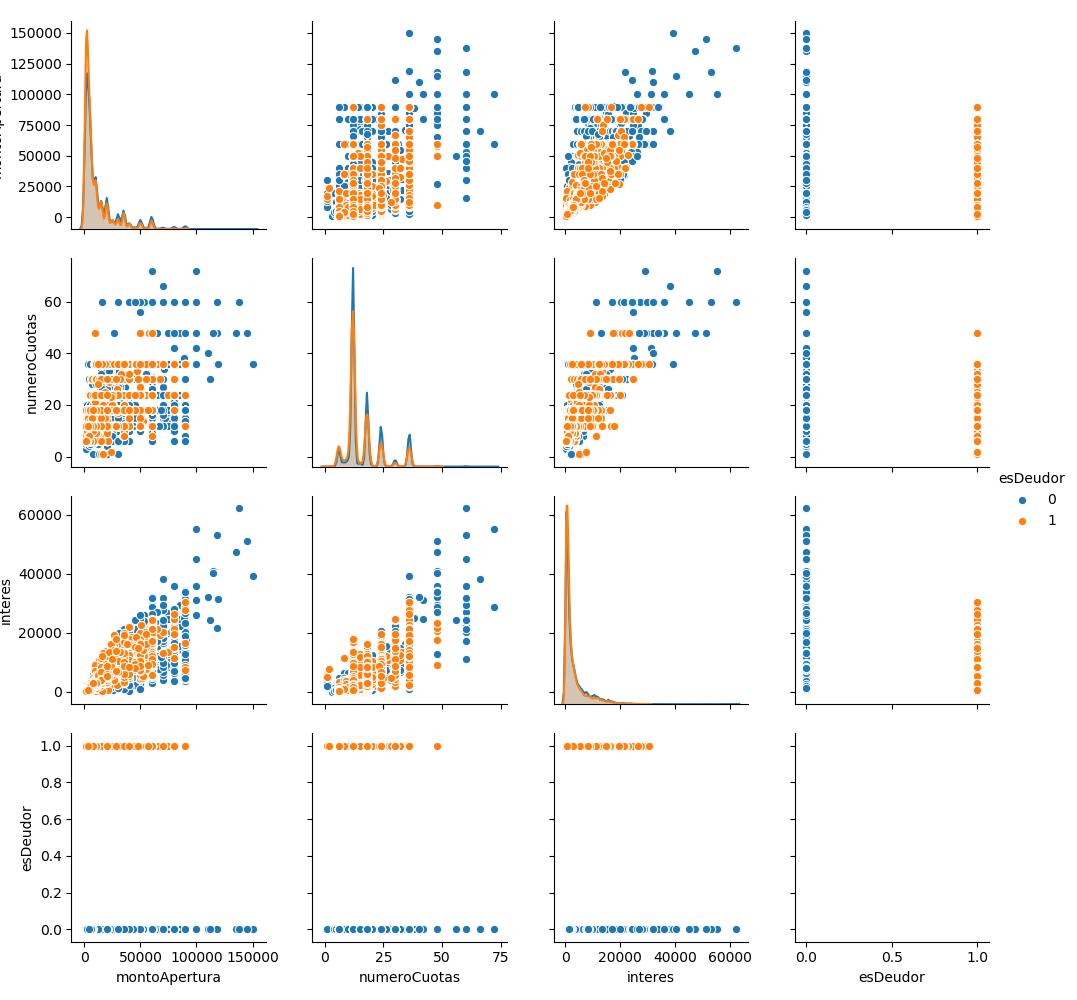

In [10]:
%matplotlib notebook
dfCompleto.drop(['montoCancelado'], axis=1, inplace=True)
sns.pairplot(dfCompleto[['montoApertura', 'numeroCuotas', 'interes', 'esDeudor']], hue="esDeudor")

_Cambiando numeroCuotas a categorico periodos_

<IPython.core.display.Javascript object>


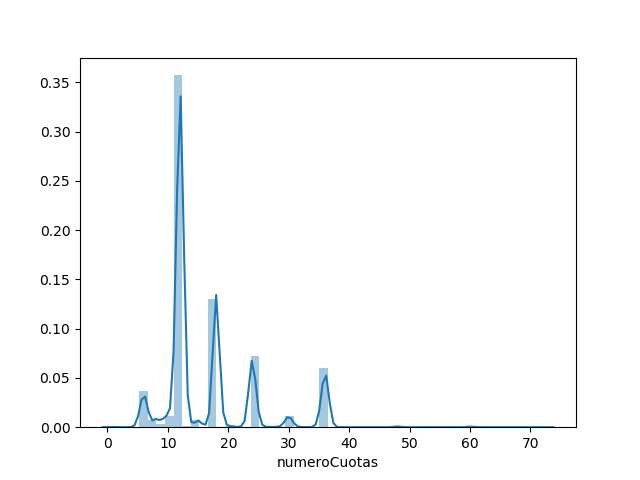

sem2     16015
sem3      5875
sem4      3127
sem6      2544
sem1      1558
sem5       541
sem7+       68
Name: periodos, dtype: int64

In [11]:
sns.distplot(dfCompleto['numeroCuotas'])
dfCompleto['periodos'] = np.int32(np.ceil(dfCompleto.numeroCuotas/6))
dfCompleto['periodos'] = dfCompleto['periodos'].apply(lambda x: x if x < 7 else 9)
dfCompleto.periodos = dfCompleto.periodos.apply(str)
dfCompleto['periodos'] = dfCompleto.periodos.apply(lambda x: "sem"+str(x))
dfCompleto.periodos.replace(to_replace=dict(sem9 = 'sem7+'), inplace=True)
display(pd.value_counts(dfCompleto.periodos))


### Segmentación por monto apertura, sector y tipo de crédito

<IPython.core.display.Javascript object>


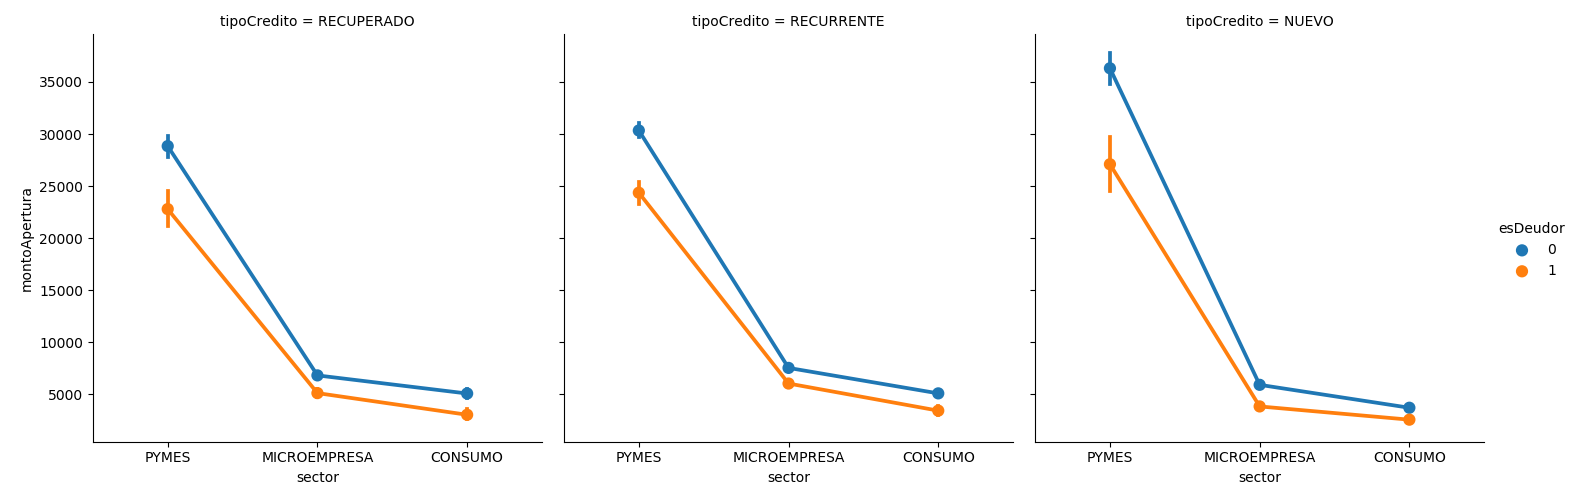

In [37]:
%matplotlib notebook
#g = sns.catplot(x="tipoCredito", y="montoApertura", hue="destinoCredito", col="esDeudor", data=dfCompleto, kind="bar")
g = sns.catplot(x="sector", y="montoApertura", hue="esDeudor", col="tipoCredito", data=dfCompleto, kind="point")#boxen
#tipoCredito|sector|destinoCredito

### Segmentación por interes, destino y tipo de crédito

<IPython.core.display.Javascript object>


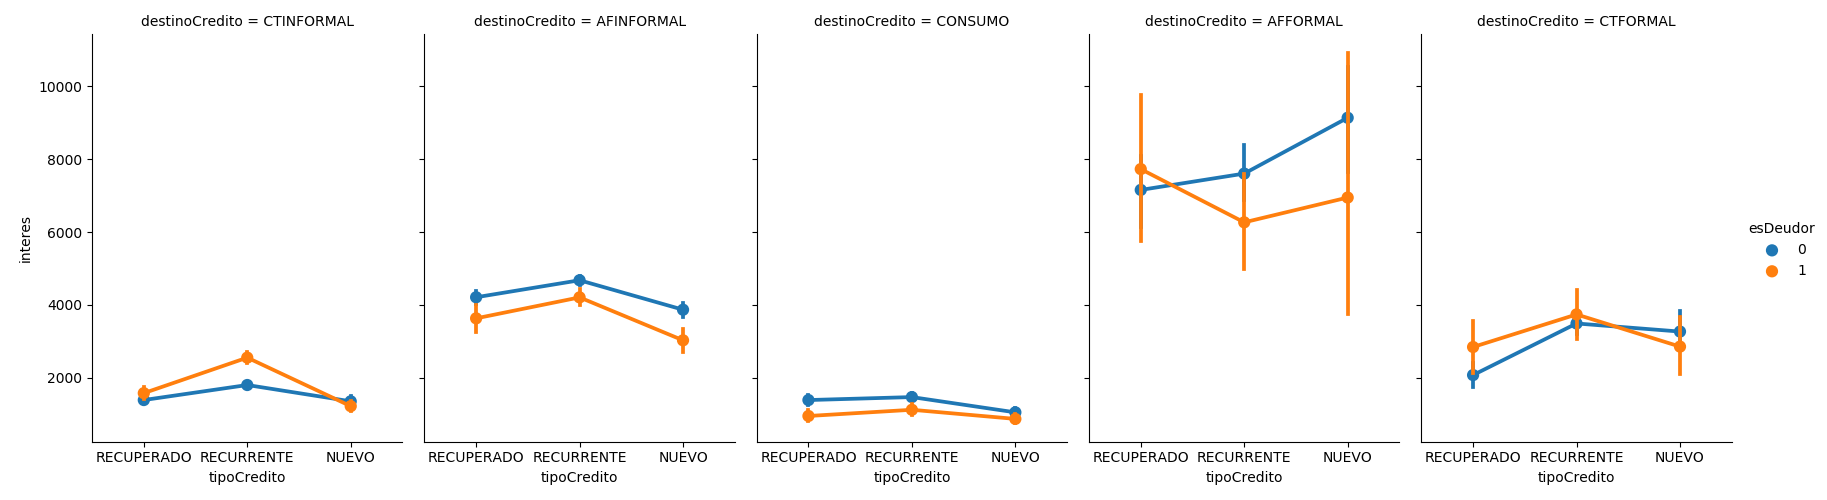

In [44]:
g = sns.catplot(x="tipoCredito", y="interes", hue="esDeudor", col="destinoCredito", data=dfCompleto, kind="point", aspect=.7)
plt.show()

### Distribución de Deudores según interés y número de Cuotas

<IPython.core.display.Javascript object>


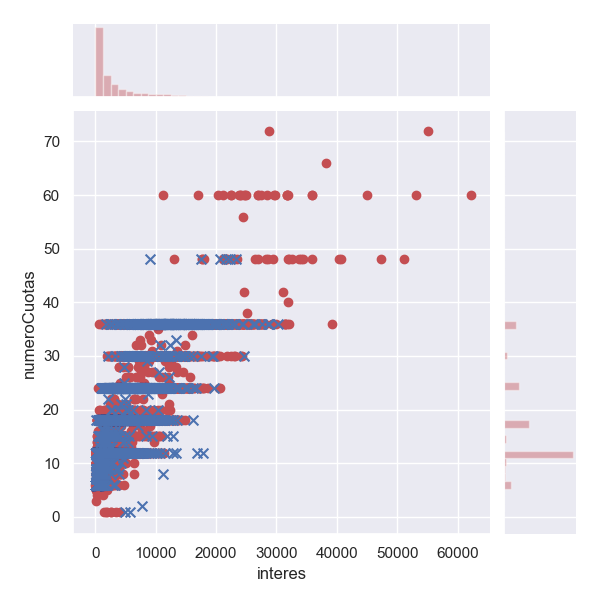

In [75]:
dfDeudor = dfCompleto.loc[dfCompleto['esDeudor'] == 1]
dfNoDeudor = dfCompleto.loc[dfCompleto['esDeudor'] == 0]
graph = sns.jointplot(x=dfNoDeudor.interes, y=dfNoDeudor.numeroCuotas, color="r");
graph.x = dfDeudor.interes
graph.y = dfDeudor.numeroCuotas
graph.plot_joint(plt.scatter, marker='x', c='b', s=50)

In [86]:
dfCompleto.to_csv("data/compartamosFiltrado.csv")